In [1]:
import squidpy as sq
import scanpy as sc
import pandas as pd
import numpy as np

/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
import liana as li

In [3]:
from matplotlib.pyplot import hist

In [4]:
# load the pre-processed dataset
img = sq.datasets.visium_hne_image()
adata = sq.datasets.visium_hne_adata()

In [5]:
li.mt.get_spatial_proximity(adata=adata, parameter=200, bypass_diagonal=False, cutoff=0.2)

In [6]:
my_plot = li.pl.proximity_plot(adata, idx=100)

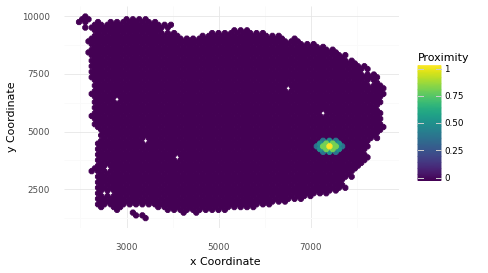

<ggplot: (8754306228974)>

In [7]:
my_plot

In [8]:
from liana.method.sp._spatialdm import spatialdm

In [9]:
spatialdm(adata=adata, resource_name="MouseConsensus", pvalue_method='analytical', verbose=True, use_raw=False)

Using `.X`!


In [10]:
from liana.method._global_lr_pipe import _global_lr_pipe
from liana.method.sp._spatialdm import _get_ordered_matrix, _standardize_matrix

In [11]:
temp, lr_res, ligand_pos, receptor_pos = _global_lr_pipe(adata=adata,
                                                         resource_name="MouseConsensus",
                                                         expr_prop=0.05,
                                                         use_raw=False,
                                                         verbose=True,
                                                         layer=None,
                                                         resource=None,
                                                         _key_cols=['ligand_complex', 'receptor_complex'],
                                                         _complex_cols=['ligand_means', 'receptor_means'],
                                                         _obms_keys=['proximity']
                                                         )

Using `.X`!


In [12]:
lr_res.head()

,interaction,ligand,receptor,ligand_complex,receptor_complex,ligand_means,ligand_props,receptor_means,receptor_props,prop_min
0,Dll1&Notch1,Dll1,Notch1,Dll1,Notch1,0.037283,0.057292,0.216689,0.276786,0.057292
1,Adam10&Notch1,Adam10,Notch1,Adam10,Notch1,0.623617,0.651786,0.216689,0.276786,0.276786
2,Jag1&Notch1,Jag1,Notch1,Jag1,Notch1,0.051299,0.075893,0.216689,0.276786,0.075893
3,Adam17&Notch1,Adam17,Notch1,Adam17,Notch1,0.121026,0.167783,0.216689,0.276786,0.167783
4,Dlk1&Notch1,Dlk1,Notch1,Dlk1,Notch1,0.236641,0.213542,0.216689,0.276786,0.213542


In [13]:
x_mat = _standardize_matrix(temp.X, local=False)
y_mat = _standardize_matrix(temp.X, local=False)

In [14]:
ligand_mat = _get_ordered_matrix(x_mat, ligand_pos, lr_res.ligand)
receptor_mat = _get_ordered_matrix(y_mat, receptor_pos, lr_res.receptor)

In [15]:
dist = adata.obsm['proximity']

In [16]:
global_r = ((ligand_mat @ dist) * receptor_mat).sum(axis=1)

In [17]:
global_r

array([ 0.0786576 , -0.05555834, -0.00536108, ...,  0.11324887,
        0.08164825, -0.36794403], dtype=float32)

Weighed Spearman Correlation:

In [18]:
import numpy as np
from scipy.stats import spearmanr, pearsonr, pointbiserialr, kendalltau

# Assume you have two arrays of data, x and y, and a weight array, w
x = np.array([2, 2, 3, 4, 5, 7])
y = np.array([1, 2, 3, 4, 5, 9])
w = np.array([0.1, 0.2, 0.3, 0.2, 0.2, 0.5])

In [19]:
xw = x * w
yw = y * w

In [20]:
spearmanr(x, y)

SpearmanrResult(correlation=0.9856107606091624, pvalue=0.0003090856678496655)

In [21]:
spearmanr(xw, yw)

SpearmanrResult(correlation=1.0, pvalue=0.0)

Global Correlations

In [22]:
ligand_mat = _get_ordered_matrix(temp.X, ligand_pos, lr_res.ligand)
receptor_mat = _get_ordered_matrix(temp.X, receptor_pos, lr_res.receptor)

In [23]:
x, y = ligand_mat[ligand_pos['Agt']], receptor_mat[receptor_pos['Mas1']]
w = temp.obsm['proximity']

In [24]:
xw = (x @ w).A.flatten()
yw = (y @ w).A.flatten()

In [25]:
spearmanr(xw, yw, nan_policy='omit')

SpearmanrResult(correlation=-0.19361405326303585, pvalue=4.0906054228731085e-24)

In [26]:
pearsonr(xw, yw)

(-0.23586946928674207, 2.661972842595147e-35)

Time to beat

In [27]:
ligand_mat = _get_ordered_matrix(temp.X, ligand_pos, lr_res.ligand)
receptor_mat = _get_ordered_matrix(temp.X, receptor_pos, lr_res.receptor)

In [28]:
xw = (ligand_mat @ w)
yw = (receptor_mat @ w)

In [29]:
%%time
corrs = []
for i in range(xw.shape[0]):
    corrs.append(spearmanr(xw[i,:].A.flatten(), yw[i,:].A.flatten())[0])
corrs = np.array(corrs)

CPU times: user 24 s, sys: 0 ns, total: 24 s
Wall time: 24 s


(array([  3.,  24.,  63., 158., 409., 427., 192.,  74.,  44.,  15.]),
 array([-0.61308261, -0.47603098, -0.33897935, -0.20192773, -0.0648761 ,
         0.07217553,  0.20922716,  0.34627878,  0.48333041,  0.62038204,
         0.75743367]),
 <BarContainer object of 10 artists>)

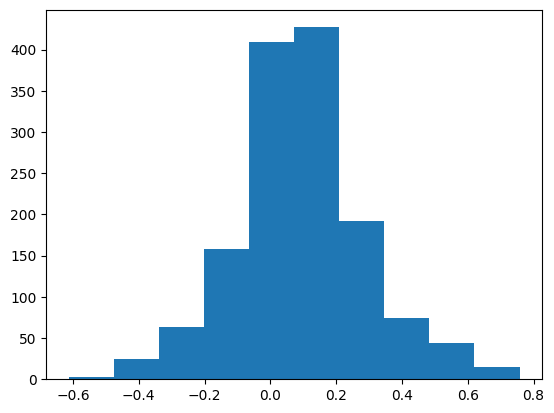

In [30]:
hist(corrs)

Re-implement correlations, needed for efficient local corr.

In [31]:
from scipy.stats import rankdata

In [32]:
def _wcov(x, y, w, mx, my):
    # calculate unscaled weighed correlation
    return np.sum(w * (x - mx) * (y - my))

def _pearson(x, y, w):
    # calculate means
    mx, my = (np.sum(i * w) / np.sum(w) for i in [x, y])
    # scale to 0 to 1
    return _wcov(x, y, w, mx, my) / np.sqrt(_wcov(x, x, w, mx, my) * _wcov(y, y, w, mx, my))

In [33]:
def _rank(x):
    return rankdata(x, method="average")

def _spearman(x, y, w):
    return _pearson(_rank(x), _rank(y), w)

In [34]:
x, y = ligand_mat[ligand_pos['Agt']].A.flatten(), receptor_mat[receptor_pos['Mas1']].A.flatten()

In [35]:
_spearman(x, y, w)

-0.19600322558729438

In [36]:
_pearson(x, y, w)

-0.23326233

In [37]:
#^ Basic test

Re-implement as an efficient matrix operation

In [58]:
ligand_mat = _get_ordered_matrix(temp.X, ligand_pos, lr_res.ligand)
receptor_mat = _get_ordered_matrix(temp.X, receptor_pos, lr_res.receptor)

In [59]:
corr_method = "pearson"

In [60]:
xw = (ligand_mat @ w)
yw = (receptor_mat @ w)

In [61]:
xw.shape

(1409, 2688)

In [62]:
if corr_method=='spearman':
    xw = np.asmatrix(rankdata(xw.todense(), axis=1, method="average"))
    yw = np.asmatrix(rankdata(yw.todense(), axis=1, method="average"))

In [63]:
xw.shape

(1409, 2688)

In [64]:
xm = (xw - xw.mean(axis=1)).A
ym = (yw - yw.mean(axis=1)).A

In [65]:
numerator = np.sum(xm * ym, axis=1)

In [66]:
denumerator = np.sqrt((np.sum(np.power(xm, 2), axis=1) * np.sum(np.power(ym, 2), axis=1)))

In [67]:
corrs = numerator / denumerator

In [68]:
corrs.shape

(1409,)

(array([ 11.,  43., 130., 279., 468., 256., 121.,  66.,  28.,   7.]),
 array([-0.53516597, -0.39648888, -0.2578118 , -0.11913473,  0.01954235,
         0.15821943,  0.29689652,  0.43557358,  0.57425064,  0.71292776,
         0.8516048 ], dtype=float32),
 <BarContainer object of 10 artists>)

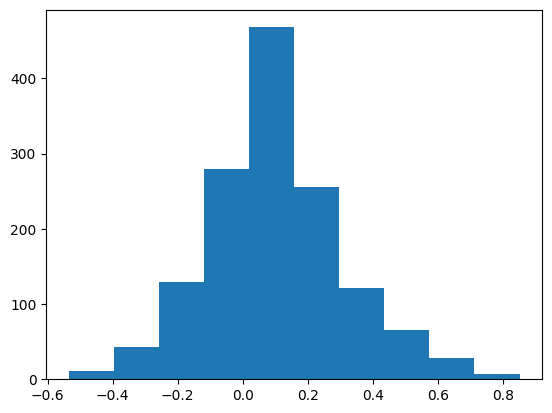

In [69]:
hist(corrs)

Compare to Global Moran's I

In [70]:
adata.uns['global_res']['spearman'] = corrs

In [73]:
spearmanr(adata.uns['global_res']['global_r'], adata.uns['global_res']['spearman'])

SpearmanrResult(correlation=0.9095009278189768, pvalue=0.0)

Local Correlations

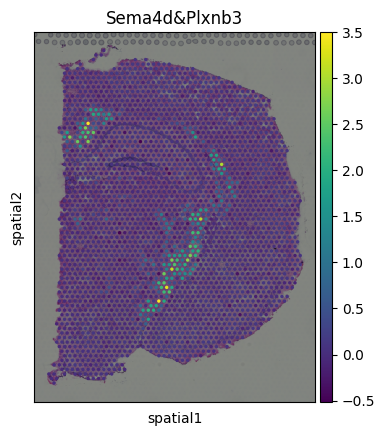

In [80]:
# showcase moran's I
local_r = li.ut.obsm_to_adata(adata, obsm_key='local_r')
sc.pl.spatial(local_r, color=['Sema4d&Plxnb3'])